In [2]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Configs:
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = False

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'mnist'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    DIM_CONTEXT : int = 0
    VOCAB_SIZE : int = 2
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (1, 28, 28))
    FLAT_IMAGE : bool = True

    # #...model params:
    MODEL : str = 'StateClassifier'
    DIM_HIDDEN : int = 128
    DIM_TIME_EMB : int = 16
    DIM_STATE_EMB : int = 8
    NUM_LAYERS : int = 2
    DROPOUT : float = 0.
    ACTIVATION : str = 'ReLU'
    TIME_EMBEDDING_TYPE : str = 'sinusoidal'

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    EPOCHS: int = 500
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cjb params:
    DYNAMICS : str = 'ConditionalJumpBridge'
    GAMMA: float = 0.1

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 2e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'TauLeaping'
    NUM_TIMESTEPS : int = 100
    TIME_EPS : float = 1e-3

    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


# Data

In [4]:
from torchvision.transforms import ToPILImage
from cmb.data.binary_mnist import MNISTDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
mnist = MNISTDataClass(conf)
dataloader = DefineDataloader(mnist)
transform = ToPILImage()

for batch in dataloader.train:
    pair = torch.cat([batch.source[0].view(1, 28,28), batch.target[0].view( 1, 28,28)], dim=1)
    img = transform(pair)
    break

img

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


# Train model

In [3]:
# from cmb.dynamics.cjb import ConditionalJumpBridge
# from cmb.models.architectures.state_classifier import StateClassifier 
# from cmb.models.trainers import CFMTrainer

# conf = Configs()
# mnist = MNISTDataClass(conf)
# dynamics = ConditionalJumpBridge(conf)
# classifier = StateClassifier(conf)
# generative_model = CFMTrainer(dynamics, classifier, mnist)
# generative_model.train()

2024-08-07 17:49:04.480893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 17:49:04.525344: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 17:49:04.526111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 17:49:05.247646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 305056
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

# Generate samples

In [8]:
import torch
from dataclasses import dataclass
from torch.nn.functional import softmax

class TransitionRateModel(torch.nn.Module):
    def __init__(self, model, config):
        super().__init__()
        self.model = model # model should output logits
        self.vocab_size = config.VOCAB_SIZE
        self.config = config
        self.gamma = config.GAMMA
        self.time_epsilon = config.TIME_EPS

    def forward(self, t, s, context=None):
        t = t.squeeze()
        if len(s.shape) != 2:
            s = s.reshape(s.size(0),-1)
        logits = self.model(t, s, context)
        t1 = 1. - self.time_epsilon
        beta_integral = (t1 - t) * self.gamma
        wt = torch.exp(-self.vocab_size * beta_integral)
        A, B, C = 1. , (wt * self.vocab_size)/(1. - wt) , wt
        qx = softmax(logits, dim=2)
        qy = torch.gather(qx, 2, s.long().unsqueeze(2))
        rate = A + B[:, None, None] * qx + C[:, None, None] * qy
        return rate

class TauLeapingSolver:
    def __init__(self, transition_rate, device):
        self.transition_rate = transition_rate
        self.device = device

    def simulate(self, x, t_span):
        time_steps = len(t_span)
        tau = (t_span[-1] - t_span[0]) / (time_steps - 1)
        trajectory = [x]

        for i in range(1, time_steps):
            t = t_span[i-1]
    
            current_state = x.clone()
            rates = self.transition_rate(t, current_state).to(self.device)
            voc_size = rates.size(-1) 

            jumps = torch.poisson(rates * tau).to(self.device)  
            net_jumps = torch.argmax(jumps, dim=-1).type_as(current_state)
            x = torch.clamp(net_jumps, min=0, max=voc_size-1)            
            trajectory.append(x.clone())

        return torch.stack(trajectory)

class ContextWrapper(torch.nn.Module):
    """ Wraps model to torchdyn compatible format.
    """
    def __init__(self, net, context=None):
        super().__init__()
        self.nn = net
        self.context = context

    def forward(self, t, x):
        t = t.repeat(x.shape[0])
        t = self.reshape_time_like(t, x)
        return self.nn(t=t, s=x, context=self.context)

    def reshape_time_like(self, t, x):
        if isinstance(t, (float, int)): return t
        else: return t.reshape(-1, *([1] * (x.dim() - 1)))


class CJBPipeline:
    
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=True,
                 ):

        self.config = config
        self.model = trained_model.best_epoch_model if best_epoch_model else trained_model.last_epoch_model
        self.num_sampling_steps = config.NUM_TIMESTEPS
        self.sampler = config.SAMPLER
        self.device = config.DEVICE
        self.vocab_size = config.VOCAB_SIZE
        self.has_context = True if config.DIM_CONTEXT > 0 else False
        self.time_steps = torch.linspace(0.0, 1.0 - config.TIME_EPS, self.num_sampling_steps, device=self.device)

    @torch.no_grad()
    def generate_samples(self, input_source, context=None):
        self.source = input_source.to(self.device) 
        self.context = context.to(self.device) if self.has_context else None
        self.jumps = self.MarkovSolver() 

    @torch.no_grad()
    def MarkovSolver(self):
        rate = TransitionRateModel(self.model, self.config)
        rate = ContextWrapper(rate, context=self.context if self.context is not None else None)
        tauleap = TauLeapingSolver(transition_rate=rate, device=self.device)        
        return tauleap.simulate(x=self.source, t_span=self.time_steps).detach().cpu()



In [9]:
from cmb.dynamics.cjb import ConditionalJumpBridge
from cmb.models.architectures.state_classifier import StateClassifier 
from cmb.models.trainers import CFMTrainer
from cmb.data.binary_mnist import MNISTDataClass

conf = Configs()
mnist = MNISTDataClass(conf)
dynamics = ConditionalJumpBridge(conf)
classifier = StateClassifier(conf)
generative_model = CFMTrainer(dynamics, classifier, mnist)
generative_model.load(model='best')

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


In [27]:

conf.GAMMA = 0.005
conf.NUM_TIMESTEPS = N = int(1. / conf.GAMMA)
conf.TIME_EPS = 0.


pipeline = CJBPipeline(trained_model=generative_model, config=conf)
input_source = torch.randint(0, 2, (128, 784))

pipeline.generate_samples(input_source)
sample = pipeline.jumps.view(N, 128, 1, 28, 28).float()

print('number of timesteps: {}'.format(N))

number of timesteps: 200


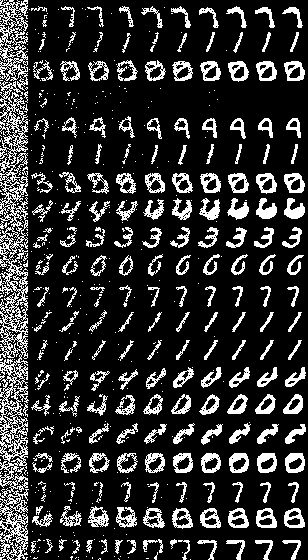

In [28]:
import random
from torchvision.transforms import ToPILImage


transform = ToPILImage()

generated_sample = []

for idx in random.sample(range(0, 128), 20):
    img = []
    for time_step in range(0, N, N//10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)
